In [110]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [111]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
	cols.append(df.shift(-n_out))
	if n_out == 0:
		names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
	else:
		names += [('var%d(t+%d)' % (j+1, n_out)) for j in range(n_vars)]
        
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [112]:
#load daraset
path = r'C:\Users\nailt\Desktop\PowerIoT\Datasets\powerandweather.csv'
pathEnes=r'C:\Users\enes_\Desktop\Datasets\powerandweather.csv'
dataset= read_csv(pathEnes, header=0, index_col='time')



In [113]:
#dataset.tail(20)

In [114]:
dataset.replace([np.inf ,-np.inf],np.nan)
dataset.fillna(method='ffill')
values=dataset.values

In [115]:
# normalize features
data=dataset
data['cloudCover'] = (data['cloudCover']- data['cloudCover'].min())/(data['cloudCover'].max()-data['cloudCover'].min())
data['dewPoint'] = (data['dewPoint']-data['dewPoint'].min())/(data['dewPoint'].max()-data['dewPoint'].min())
data['humidity'] = (data['humidity']-data['humidity'].min())/(data['humidity'].max()-data['humidity'].min())
data['temperature'] = (data['temperature']-data['temperature'].min())/(data['temperature'].max()-data['temperature'].min())
data['pressure'] = (data['pressure']-data['pressure'].min())/(data['pressure'].max()-data['pressure'].min())
data['windBearing'] = (data['windBearing']-data['windBearing'].min())/(data['windBearing'].max()-data['windBearing'].min())
data['windSpeed'] = (data['windSpeed']-data['windSpeed'].min())/(data['windSpeed'].max()-data['windSpeed'].min())
#data['power'] = (data['power']-data['power'].min())/(data['power'].max()-data['power'].min())
data['power']=data['power']/50000

scaled=data


In [116]:
# frame as supervised learning
prediction_step=15
windows_size=10
reframed = series_to_supervised(scaled, windows_size, prediction_step)

In [117]:
#reframed.head(10)

In [118]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-2,-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)

In [119]:
#reframed.head(20)

In [120]:
#reframed.columns


In [121]:
len_data=len(reframed);
train_len= int(len_data*0.98);

# split into train and test sets
values = reframed.values
train = values[:train_len, :]
test = values[train_len:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)




Train on 16918 samples, validate on 346 samples
Epoch 1/50
 - 2s - loss: 0.0997 - acc: 0.4483 - val_loss: 0.1132 - val_acc: 0.3497
Epoch 2/50
 - 0s - loss: 0.0803 - acc: 0.4483 - val_loss: 0.1059 - val_acc: 0.3497
Epoch 3/50
 - 0s - loss: 0.0759 - acc: 0.4483 - val_loss: 0.1030 - val_acc: 0.3497
Epoch 4/50
 - 0s - loss: 0.0731 - acc: 0.4483 - val_loss: 0.0996 - val_acc: 0.3497
Epoch 5/50
 - 0s - loss: 0.0706 - acc: 0.4483 - val_loss: 0.1027 - val_acc: 0.3497
Epoch 6/50
 - 0s - loss: 0.0690 - acc: 0.4483 - val_loss: 0.0938 - val_acc: 0.3497
Epoch 7/50
 - 0s - loss: 0.0672 - acc: 0.4483 - val_loss: 0.0918 - val_acc: 0.3497
Epoch 8/50
 - 0s - loss: 0.0661 - acc: 0.4483 - val_loss: 0.0924 - val_acc: 0.3497
Epoch 9/50
 - 0s - loss: 0.0647 - acc: 0.4483 - val_loss: 0.0932 - val_acc: 0.3497
Epoch 10/50
 - 0s - loss: 0.0638 - acc: 0.4483 - val_loss: 0.0955 - val_acc: 0.3497
Epoch 11/50
 - 0s - loss: 0.0630 - acc: 0.4483 - val_loss: 0.0954 - val_acc: 0.3497
Epoch 12/50
 - 0s - loss: 0.0623 - ac

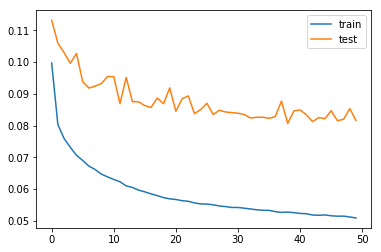

In [122]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', metrics=['accuracy'],optimizer='rmsprop')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=True)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [123]:
#yhat = model.predict(test_X)

In [124]:
#yhat.shape

In [125]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

test_y = test_y.reshape((len(test_y), 1))

# calculate RMSE
rmse = sqrt(mean_squared_error(yhat,test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.157


In [126]:
import time
predictSTR= 'prediction for  '+ str(prediction_step*5) +' minute'


In [127]:
#import pandas as pd
#asa = list(test_y*50000)
#df=pd.DataFrame(asa)
#df.to_csv('test_y.csv',index = False)

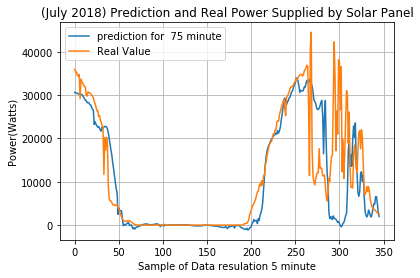

Test RMSE: 0.157


In [128]:
pyplot.plot(yhat*50000, label= predictSTR)
pyplot.plot(test_y*50000, label= 'Real Value')
pyplot.legend()
pyplot.xlabel('Sample of Data resulation 5 minute')
pyplot.ylabel('Power(Watts)')
pyplot.title('(July 2018) Prediction and Real Power Supplied by Solar Panel')
pyplot.grid(True)
pyplot.show()
print('Test RMSE: %.3f' % rmse)



In [129]:
#import pandas as pd
#df= pd.DataFrame(yhat)
#df.to_csv("yhat.csv",index=False)
#df= pd.DataFrame(test_y)
#df.to_csv("test.csv",index=False)


In [130]:
#df= pd.DataFrame(test_X[:,0])
#df.to_csv('cloudcover.csv', index=False)

In [131]:
test_X.shape

(346, 80)

In [132]:
len(yhat)

346

In [133]:
len(test_y)

346